<a href="https://colab.research.google.com/github/aryanasadianuoit/Adaptive-Graph-Based-Cohort-Creation-For-Deep-MutualLearning/blob/master/adaptive_graph_for_deep_mutual_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model 1 : 
Initial training
Epoch 1/2
1563/1563 [==============================] - 4s 3ms/step - loss: 3.7302 - accuracy: 0.1304
Epoch 2/2
1563/1563 [==============================] - 4s 3ms/step - loss: 2.9725 - accuracy: 0.2621
dict_keys(['loss', 'accuracy'])


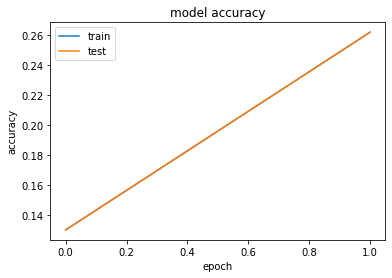

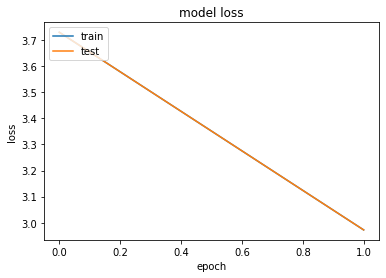

KeyError: ignored

In [22]:
import tensorflow as tf
import numpy as np
from tensorflow import keras
import theano
from keras import backend
from keras.losses import categorical_crossentropy as logloss
from keras.layers import Lambda, concatenate, Activation
import matplotlib.pyplot as plt

cifar100 = keras.datasets.cifar100
(training_images, training_labels), (testing_images, testing_labels) = cifar100.load_data()

temperature = 5

# Reshaping and normalizing the images

training_images = training_images.reshape(50000, 32, 32, 3)
training_images = training_images / 255.0
testing_images = testing_images.reshape(10000, 32, 32, 3)
testing_images = testing_images / 255.0

cohort_list = []


def train_basic():
    print("Initial training")
    basic_model = keras.models.Sequential([keras.layers.Conv2D(filters=32, kernel_size=(3, 3),
                                                               activation=keras.activations.relu,
                                                               input_shape=(32, 32, 3)),
                                           keras.layers.MaxPool2D(2, 2),
                                           keras.layers.Conv2D(filters=64, kernel_size=(3, 3),
                                                               activation=keras.activations.relu),
                                           keras.layers.MaxPool2D(2, 2),
                                           keras.layers.Flatten(),
                                           keras.layers.Dense(units=256, activation=keras.activations.relu),
                                           keras.layers.Dense(units=100, activation=keras.activations.relu),
                                           keras.layers.Dense(units=100, activation=keras.activations.softmax)])
    #basic_model.summary()
    basic_model.compile(optimizer=keras.optimizers.Adam(),
                        loss=keras.losses.sparse_categorical_crossentropy,
                        metrics=["accuracy"])
    history = basic_model.fit(x=training_images, y=training_labels, epochs=2, verbose=1)
    print(history.history.keys())
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()  
    # summarize history for loss
    plt.plot(history.history['top_k_categorical_accuracy'])
    plt.plot(history.history['top_k_categorical_accuracy'])
    plt.title('model top_k_categorical_accuracy')
    plt.ylabel('top_k_categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()  

    return basic_model


def get_logits(basic_model):
    intermediate_input = basic_model.input
    intermediate_output = basic_model.get_layer(index=-2).output
    intermediate_layer_model = keras.models.Model(inputs=intermediate_input, outputs=intermediate_output)
    intermediate_output = intermediate_layer_model.predict(x=training_images)
    return np.array(intermediate_output)


def get_probabilities(basic_model):
    softmax_layer = keras.models.Model(inputs=basic_model.input,
                                       outputs=basic_model.get_layer(index=-1).output)
    probabilities = softmax_layer.predict(x=training_images)
    return np.array(probabilities)


def get_high_temp_probabilities(basic_model):
    intermediate_layer_model = keras.models.Model(inputs=basic_model.input,
                                                  outputs=basic_model.get_layer(index=-1).output)
    intermediate_output = intermediate_layer_model.predict(x=training_images)
    intermediate_output = np.array(intermediate_output) ** (1 / temperature)
    p_sum = intermediate_output.sum()
    sample_temp = intermediate_output / p_sum
    return sample_temp


def deep_mutual_training():
    for node in cohort_list:
        for other_nodes in range(0, len(cohort_list)):
            if node is other_nodes:
                print("Same student")

            else:
               # print("Before reshape : ", np.shape(get_high_temp_probabilities(cohort_list[other_nodes])),"   ",np.shape(get_high_temp_probabilities(node)))
                truth = np.reshape(get_high_temp_probabilities(cohort_list[other_nodes]), newshape=-1)
                preds = np.reshape(get_high_temp_probabilities(node), newshape=-1)

               # print("After reshape : ", np.shape(truth),"   ",np.shape(preds))
               # print("Shapes input : ",np.shape(training_images),"  Shape of Labels : ",np.shape(training_labels))

                node.compile(optimizer=keras.optimizers.Adam(),
                             loss=lambda truth, preds: knowledge_distillation_loss(truth, preds),
                             metrics=['accuracy'])
                print("Distillation Training")
                node.fit(x=training_images, y=get_high_temp_probabilities(cohort_list[other_nodes]),
                         epochs=10, verbose=1)

def knowledge_distillation_loss(y_true, y_pred):    
    
    # split in 
    #    onehot hard true targets
    #    logits from xception
    y_true, logits = y_true[:, :100], y_true[:, 100:]
    
    # convert logits to soft targets
    y_soft = backend.softmax(logits/temperature)
    
    # split in 
    #    usual output probabilities
    #    probabilities made softer with temperature
    y_pred, y_pred_soft = y_pred[:, :100], y_pred[:, 100:]    
    
    return 2*logloss(y_true, y_pred) + logloss(y_soft, y_pred_soft)

print("Model 1 : ")
cohort_list.append(train_basic())
print("Model 2 : ")
cohort_list.append(train_basic())

#for node in cohort_list:
    #print("Node : ", node)
    #print(get_logits(node))
    #print("********************************")
    #print(get_probabilities(node))
    #print("********************************")
    #print(get_high_temp_probabilities(node))
    #print("###############################\n\n")

deep_mutual_training()

